In [1]:
import pandas as pd
import numpy as np

In [2]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum()
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
data = pd.read_csv('Dataset/data_for_model.csv')
data = reduce_mem_usage(data)

x_train = data.loc[data['sample']=='train', :].drop(['isDefault', 'sample'], axis=1)
x_train = x_train.select_dtypes(include='number')

x_test = data.loc[data['sample']=='test', :].drop(['isDefault', 'sample'], axis=1)
x_test = x_test.select_dtypes(include='number')

y_train = data.loc[data['sample']=='train', 'isDefault']
x_test = x_test.replace(np.inf, np.nan)
x_test = x_test.fillna(x_test.median())

Memory usage of dataframe is 780232448.00 MB
Memory usage after optimization is: 177994330.00 MB
Decreased by 77.2%


In [29]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=4, min_child_weight=2, subsample=0.7, objective='binary:logistic')

vclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)])
vclf = vclf.fit(x_train, y_train)
print(vclf.predict(x_test))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[0. 0. 0. ... 0. 0. 0.]
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [30]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=4, min_child_weight=2, subsample=0.7,objective='binary:logistic')
 
vclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft', weights=[2, 1, 1])
vclf = vclf .fit(x_train,y_train)
print(vclf .predict(x_test))

[0. 0. 0. ... 0. 0. 0.]
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 0.91 (+/- 0.07) [KNN]
Accuracy: 0.93 (+/- 0.05) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [Naive Bayes]
Accuracy: 0.93 (+/- 0.04) [Stacking Classifier]


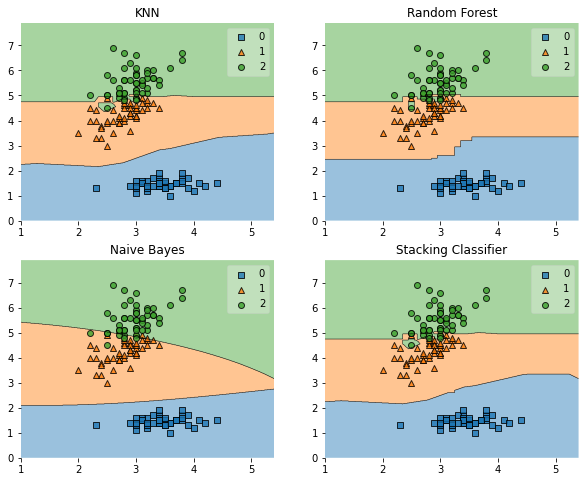

In [35]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions


# 以python自带的鸢尾花数据集为例
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target


clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)


label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)


clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)
 

plt.show()

In [39]:
from sklearn.metrics import roc_auc_score
# 以python自带的鸢尾花数据集为例
data_0 = iris.data
data = data_0[:100,:]


target_0 = iris.target
target = target_0[:100]
 
#模型融合中基学习器
clfs = [LogisticRegression(),
        RandomForestClassifier(),
        ExtraTreesClassifier(),
        GradientBoostingClassifier()]
 
#切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.3, random_state=914)


#切分训练数据集为d1,d2两部分
X_d1, X_d2, y_d1, y_d2 = train_test_split(X, y, test_size=0.5, random_state=914)
dataset_d1 = np.zeros((X_d2.shape[0], len(clfs)))
dataset_d2 = np.zeros((X_predict.shape[0], len(clfs)))
 
for j, clf in enumerate(clfs):
    #依次训练各个单模型
    clf.fit(X_d1, y_d1)
    y_submission = clf.predict_proba(X_d2)[:, 1]
    dataset_d1[:, j] = y_submission
    #对于测试集，直接用这k个模型的预测值作为新的特征。
    dataset_d2[:, j] = clf.predict_proba(X_predict)[:, 1]
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_d2[:, j]))


#融合使用的模型
clf = GradientBoostingClassifier()
clf.fit(dataset_d1, y_d2)
y_submission = clf.predict_proba(dataset_d2)[:, 1]
print("Val auc Score of Blending: %f" % (roc_auc_score(y_predict, y_submission)))

val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
val auc Score: 1.000000
Val auc Score of Blending: 1.000000
